In [137]:
import robin_stocks as r
import inspect
import math
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import yfinance
import numpy as np
import pandas as pd
from scipy.stats import norm
import datetime as dt

from tools.utils import isfloat, create_open_options_df

In [2]:
credentials = pd.read_csv("credentials.csv")
my_trader = r
token = my_trader.login(username=credentials["username"][0], password=credentials["password"][0])


In [3]:
df = create_open_options_df()

In [4]:
# df

In [5]:
df.columns

Index(['account', 'average_price', 'chain_id', 'chain_symbol', 'id', 'option',
       'type', 'pending_buy_quantity', 'pending_expired_quantity',
       'pending_expiration_quantity', 'pending_exercise_quantity',
       'pending_assignment_quantity', 'pending_sell_quantity', 'quantity',
       'intraday_quantity', 'intraday_average_open_price', 'created_at',
       'trade_value_multiplier', 'updated_at', 'url', 'option_id',
       'adjusted_mark_price', 'ask_price', 'ask_size', 'bid_price', 'bid_size',
       'break_even_price', 'high_price', 'instrument', 'last_trade_price',
       'last_trade_size', 'low_price', 'mark_price', 'open_interest',
       'previous_close_date', 'previous_close_price', 'volume',
       'chance_of_profit_long', 'chance_of_profit_short', 'delta', 'gamma',
       'implied_volatility', 'rho', 'theta', 'vega',
       'high_fill_rate_buy_price', 'high_fill_rate_sell_price',
       'low_fill_rate_buy_price', 'low_fill_rate_sell_price',
       'expiration_date', 'i

In [209]:
balance_at_execution = []
previous_balances = []
short_or_long = []
for t in df.type:
    if t == "short":
        short_or_long.append(-1)
    else:
        short_or_long.append(1)

df["short_or_long"] = short_or_long

symbols = df["chain_symbol"].unique().tolist()
stock_price = r.stocks.get_latest_price(symbols)
stock_prices = {symbols[i]:float(stock_price[i]) for i in range(len(symbols))}

df_stock_prices = []
days_to_expiry = []
for i, symbol in enumerate(df.chain_symbol):
    df_stock_prices.append(stock_prices[symbol])
    days_to_expiry.append((dt.date.fromisoformat(df.expiration_date[i]) - dt.date.today()).days)

df["days_to_expiry"] = days_to_expiry       
df["stock_price"] = df_stock_prices
# normalize gamma to reflect change in option per 1% change in stock
df["normalized_delta"] = df.delta*df.stock_price/100
df["balance_at_execution"] = df.adjusted_mark_price*df.short_or_long*100
df["previous_balance"] = df.previous_close_price*df.short_or_long*100
df["delta_move"] = df.delta*df.short_or_long*100*df.quantity
df["gamma_move"] = df.gamma*df.short_or_long*100*df.quantity
df["vega_move"] = df.vega*df.short_or_long*100*df.quantity
df["theta_move"] = df.theta*df.short_or_long*100*df.quantity
df["normalized_delta_move"] = df.normalized_delta*df.short_or_long*100*df.quantity

In [210]:
# df.implied_volatility

In [257]:
df["cost"] = df["average_price"]*df["quantity"]
df["value"] = df["balance_at_execution"]*df["quantity"]
df["previous_value"] = df["previous_balance"]*df["quantity"]
df["profit"] = df.value - df.cost
df["previous_profit"] = df.previous_value - df.cost
df["profit_percent"] = df["profit"]/df["cost"]
df["value_delta"] = df["value"] - df["previous_value"]
df["profit_delta"] = df["profit"] - df["previous_profit"]
df["value_delta_percent"] = df.value_delta/df["previous_value"]
df["profit_delta_percent"] = df.profit_delta/df["previous_profit"]
profit_cdf = []
profits_50 = []
profits_75 = []
profits_25 = []
for i,s in enumerate(df.stock_price):
    iv = df.implied_volatility[i]
    x = df.strike_price[i]
    t = df.days_to_expiry[i]/365
#     print(iv, s, x, t, df.chain_symbol[i], df.adjusted_mark_price[i])
#     input()
    profit_cdf.append(prob_stock_value(iv, s, x, t))
    profits_50.append(price_move_for_given_prob(0.5, iv, s, t))
    profits_75.append(price_move_for_given_prob(0.75, iv, s, t))
    profits_25.append(price_move_for_given_prob(0.25, iv, s, t))

df["profits_50"] = profits_50
df["profits_75"] = profits_75
df["profits_25"] = profits_25
df["ev_50"] = (0.5*(df.profits_50 - df.strike_price)*df.short_or_long*100 - 0.5*df.average_price)*df.quantity
df["ev_75"] = (0.75*(df.profits_75 - df.strike_price)*df.short_or_long*100 - 0.25*df.average_price)*df.quantity
df["ev_25"] = (0.25*(df.profits_25 - df.strike_price)*df.short_or_long*100 - 0.75*df.average_price)*df.quantity

df["computed_delta"] = profit_cdf    

In [259]:
# df.ev_75 - df.ev_50
# df[["chain_symbol", "profits_50", "profits_25", "implied_volatility", "stock_price", "strike_price", "ev_25", "ev_75", "average_price", "adjusted_mark_price"]]

In [269]:
# calculate group statistics
group_cols = ["profit", "value", "cost", "previous_value", "previous_profit", "quantity",
              "delta_move", "gamma_move", "vega_move", "theta_move", "normalized_delta_move",
              "ev_75", "ev_25", "ev_50"]
g = df.groupby(["chain_symbol"], as_index=False)[group_cols].sum()
g["value_delta"] = g["value"] - g["previous_value"]
g["profit_delta"] = g["profit"] - g["previous_profit"]
g["value_delta_percent"] = g.value_delta/g["previous_value"]
g["profit_delta_percent"] = g.profit_delta/g["previous_profit"]
g["profit_percent"] = g.profit/g.cost
g.sort_values(by="profit_delta")

# total profit
total_profit = g.profit.sum()
g["profit_ratio"] = g.profit/total_profit

#current stock price


In [270]:
def prob_stock_value(iv, s, x, t, r=0.008):
    # CDF((1 / σ√T) * (ln(S/X) + (r + σ²/2)T)
    #( math.log(self.s/self.k) + ( self.rf + math.pow( self.vol, 2)/2 ) * self.t ) / ( self.vol * math.sqrt(self.t) )
    #d1 = (np.log(S/K)+(r+variance)*T)/(v*np.sqrt(T))
    rv = norm()
    term_1 = 1 / (iv*math.sqrt(t))
    term_2 = math.log(s/x)
    term_3 = (r + (iv*iv*0.5))*t
    cdf_arg = term_1*(term_2 + term_3)
    cdf = rv.cdf(cdf_arg)
    return cdf

def price_move_for_given_prob(p, iv, s, t, r=0.008):
    exponent = (norm.ppf(p)*iv*math.sqrt(t) - r - (iv*iv*t)/2)
    x = s/math.exp(exponent)
    return x

In [272]:
g

,chain_symbol,profit,value,cost,previous_value,previous_profit,quantity,delta_move,gamma_move,vega_move,...,normalized_delta_move,ev_75,ev_25,ev_50,value_delta,profit_delta,value_delta_percent,profit_delta_percent,profit_percent,profit_ratio
0,BLNK,5505.0000,10825.0,5320.0000,8125.0,2805.0000,15.0,1030.8630,35.4810,52.6290,...,287.610777,-3907.251767,3581.293610,2615.210682,2700.0,2700.0,0.332308,0.962567,1.034774,0.131596
1,CRSR,3441.0000,8525.0,5084.0000,11120.0,6036.0000,26.0,585.6623,11.4309,52.5174,...,228.408297,1816.804552,3815.441206,4736.132085,-2595.0,-2595.0,-0.233363,-0.429920,0.676829,0.082256
2,ENPH,9549.6666,16713.0,7163.3334,16538.0,9374.6666,18.0,337.4181,-5.9171,76.5499,...,472.419419,11210.504858,4833.677520,10065.064230,175.0,175.0,0.010582,0.018667,1.333132,0.228283
3,EOSE,-220.0000,2080.0,2300.0000,2230.0,-70.0000,10.0,474.7370,53.5150,21.8670,...,71.445545,-4483.576959,-140.237823,-1342.142834,-150.0,-150.0,-0.067265,2.142857,-0.095652,-0.005259
4,FCEL,5278.0001,7008.0,1729.9999,5946.0,4216.0001,30.0,1110.5366,-3.5685,8.7094,...,108.277319,3806.086511,4415.032528,5121.534590,1062.0,1062.0,0.178607,0.251898,3.050867,0.126169
5,FOSL,-1020.0000,1040.0,2060.0000,1245.0,-815.0000,15.0,731.4455,303.8065,7.9220,...,81.556173,-1649.099814,-1115.563318,-1016.809957,-205.0,-205.0,-0.164659,0.251534,-0.495146,-0.024383
6,FSLY,-890.0000,4190.0,5080.0000,4010.0,-1070.0000,4.0,179.7610,4.4278,50.9104,...,150.999240,-7627.662913,-1613.572541,-2991.221727,180.0,180.0,0.044888,-0.168224,-0.175197,-0.021275
7,GME,430.0000,1920.0,1490.0000,1680.0,190.0000,20.0,155.1510,-22.4760,9.9710,...,25.506824,724.935053,848.942323,1132.946289,240.0,240.0,0.142857,1.263158,0.288591,0.010279
8,JKS,-1395.0000,1815.0,3210.0000,1275.0,-1935.0000,3.0,118.7313,4.4223,30.6459,...,86.104057,-6150.438610,-1344.851512,-2666.319447,540.0,540.0,0.423529,-0.279070,-0.434579,-0.033347
9,MGNI,1204.0000,3940.0,2736.0000,3800.0,1064.0000,40.0,388.5420,-71.8880,13.0920,...,75.571419,2026.038895,334.409621,1667.777198,140.0,140.0,0.036842,0.131579,0.440058,0.028781


In [273]:
#plot profit as ratio of overall profit
# subset = g
# subset["gamma_move_ratio"] = subset.normalized_delta_move/subset.value
# plot_bubble(subset, x="gamma_move_ratio", y="profit", size="cost", figsize=12)

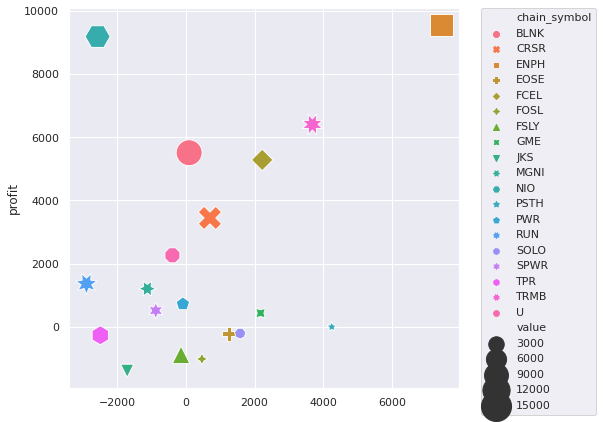

In [287]:
#plot expected profits
subset = g
subset["gamma_move_ratio"] = subset.normalized_delta_move/subset.value
unrealized_gains = (df["ev_50"] - df.profit)
plot_bubble(subset, x=unrealized_gains, y="profit", size="value", figsize=7)

In [279]:

def plot_bubble(subset, x, y, size, figsize):
    sns.set(rc={'figure.figsize':(figsize,figsize)})
    subset.profit_ratio = subset.profit/subset.profit.sum()
    sns.scatterplot(data=subset, x=x, size=size, y=y, legend="brief",
                    style="chain_symbol", hue="chain_symbol", sizes=(100,1000))
    plt.legend(bbox_to_anchor=(1.35, 1),borderaxespad=0)

In [10]:
df[["chain_symbol", "open_interest", "volume", "previous_close_price", "mark_price", "adjusted_mark_price", "profit"]]

,chain_symbol,open_interest,volume,previous_close_price,mark_price,adjusted_mark_price,profit
0,FCEL,12255.0,11585.0,1.32,1.880,1.88,17.0001
1,FCEL,1992.0,1939.0,0.94,1.335,1.34,21.0000
2,ENPH,984.0,254.0,3.98,4.275,4.28,-261.9999
3,RUN,1282.0,409.0,2.20,1.950,1.95,60.0000
4,TRMB,105.0,10.0,0.38,0.475,0.48,-80.0000
5,PSTH,5232.0,1206.0,0.43,0.675,0.68,-36.0000
6,PSTH,3221.0,1061.0,2.28,3.150,3.15,30.0000
7,MGNI,10868.0,3038.0,1.75,1.475,1.48,-1516.0000
8,MGNI,1561.0,552.0,3.65,3.450,3.45,2720.0000
9,EOSE,233.0,18.0,2.23,2.075,2.08,-220.0000
